# Light Curve Format Converter
This script serves to convert data files for light curves into a consistent format which will be supported for data ingestion into the SIMPLE database. This is a work-in-progress script, ideally this will be a script that works for most files types that could be presented. 

In [63]:
#Reading and writing files may require differing packages, but import your favorites. These are the core files I will use to perform the conversions.
#The essential nature is that the data columns, i.e. the data arrays for time, flux, and errors much be easily accessible and segragated in order to access their units. 
import pandas as pd

from astropy.io import fits
from astropy.time import Time
from astropy import units as u
import lightkurve   #The essential package these lightcurves will be made capatible with for easy reading

import lightkurve.io as l
from lightkurve.io.generic import read_generic_lightcurve #This is the necessary package which allows this 'one format' style to be read easily into SIMPLE

    The example data set I will use to demonstrate is the data from Wilson et. al. 2014 on 2MASS J00501994-3322402 as the data is only a few points and thus is easy to manipulate. The process can be performed on any data set as long as the columns are callable as was mentioned.

In [64]:
raw_data = pd.read_csv("C:/Users/kmanj/Manjavacas Research/Wilson_2014/2M0050.txt", delimiter = ' ', header = None)

In [65]:
raw_data

,0,1,2
0,0.00000,1.025077,0.009000
1,0.01833,1.059631,0.008988
2,0.03668,0.989674,0.009019
3,0.05468,0.952126,0.009004
4,0.07414,0.952839,0.009005
5,0.09190,1.016782,0.008997
6,0.10966,1.003871,0.009033


In [66]:
# Segregating the columns into the three keywords for Lightkurve to take. If there is a case when eflux is not present, the data can be read nonethless which will shown later on.

time = raw_data[0]
flux = raw_data[1]
eflux = raw_data[2]

In [67]:
# Time column for instance. Data will inevitably need to be an array (preferred) or list in order to supply a unit to it using astropy's units package.
time

0    0.00000
1    0.01833
2    0.03668
3    0.05468
4    0.07414
5    0.09190
6    0.10966
Name: 0, dtype: float64

In [68]:
# Giving our data the unit hours which will count it as some normalized time as opposed to MJD or JD.
t = np.array(time) * u.h

In [69]:
print(t)
type(t)

[0.      0.01833 0.03668 0.05468 0.07414 0.0919  0.10966] h


astropy.units.quantity.Quantity

In [79]:
# Unit is specificed as dimensionless_unscaled due to the lack of normalized flux unit provided by astropy documentation.
# Flux unit provided in documentation is in e-/s which is not consistent with most formats published. When forcing the unitlessness,
# when the fits file is automatically created, the TUNIT2 header for flux will not populate as we would like. Normalized flux would be inputted elsewhere.

f = np.array(flux) * u.dimensionless_unscaled
ef = np.array(eflux) * u.dimensionless_unscaled


In [80]:
print(f)
print(f'The unit for flux is {f.unit}.')
type(f)

[1.025077 1.059631 0.989674 0.952126 0.952839 1.016782 1.003871]
The unit for flux is .


astropy.units.quantity.Quantity

In [81]:
# Once units have been provided, the lightkurve object can be made. It requires three inputs, time, flux, and flux_err.
# If we do not have flux_err data, then the flux_err keyword can be placed as None or left off entirely. In both cases,
# when using lightkurve to plot, the errorbar feature will produced an error. 
# Time is requested to begin at zero, thus is normalized if possible.

lc = l.LightCurve(time = t, flux = f, flux_err = ef, time_format = 'jd')

#### Creating the fits file and addressing header keywords

In [93]:
# This will write the lightkurve object to a fits file with three columns specified in cell above.

lc.to_fits(path = "C:/Users/kmanj/Manjavacas Research/Example/File.fits", overwrite = True)

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x00000251AF289BD0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x00000251AF28BB50>]

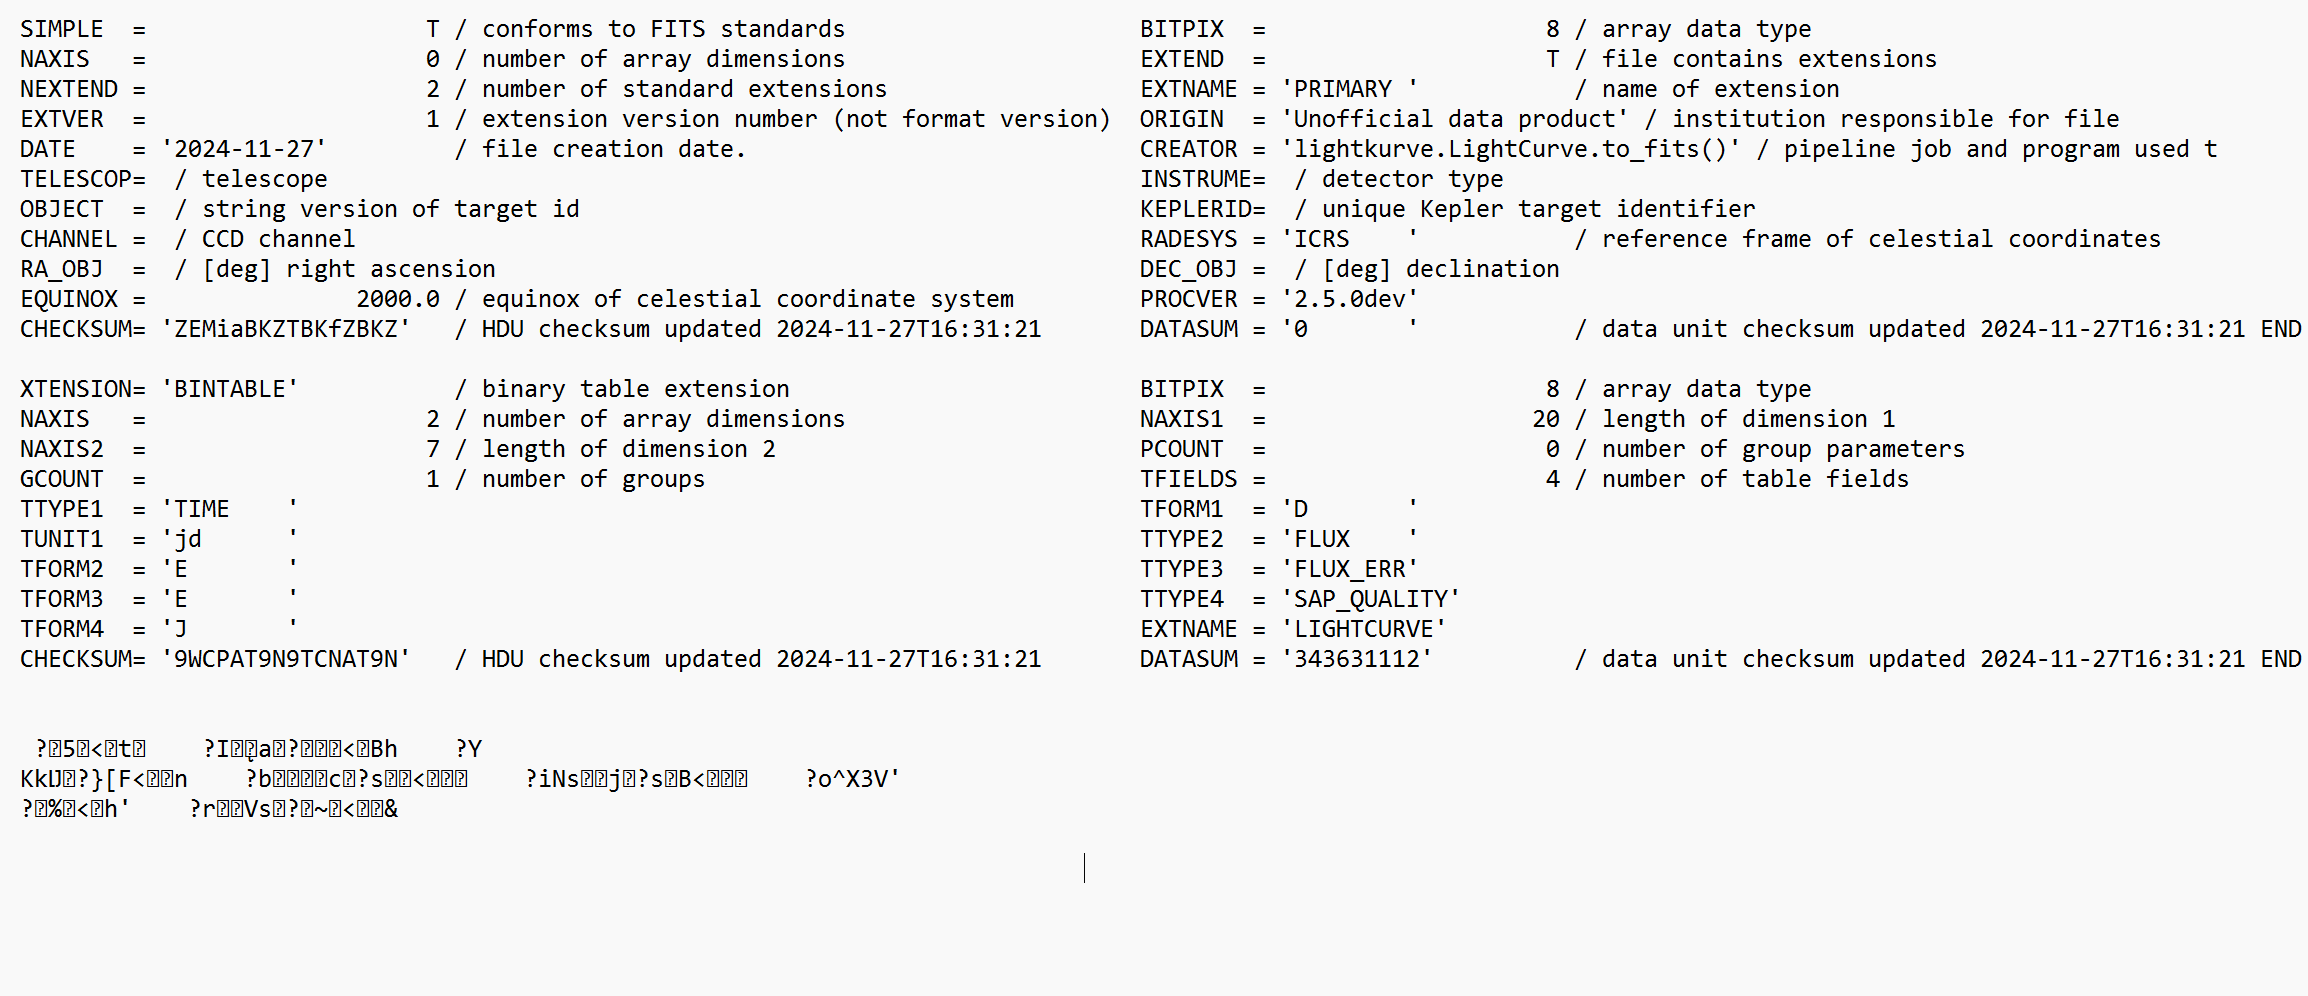

    Automatically, the created fits documents will be produced with a header like this. A source of continuous questioning and uncertainty is due to the keywords to use for these documents. We have agreed to utilize HSLP guidelines.

In [94]:
# Now comes the tedious part of populating the keywords which can be done in any of the traditional ways this would be accomplished.

with fits.open("C:/Users/kmanj/Manjavacas Research/Example/File.fits", mode = 'update') as f:
    f[0].header['OBJECT'] = '2MASS J00501994-3322402' # Full object name
    f[0].header['SPECTYPE'] = 'T7' #Spectral type
    f[0].header['TSTART'] = 55839.13744 # Start time of observation in MJD
    f[0].header['TIMESYS'] = 'mjd' # MJD here is referring to whatever the TSTART header refers to
    f[0].header['OBSERVAT'] = 'La Silla Observatory' # Observatory
    f[0].header['TELESCOP'] = 'NTT (New Technology Telescope)' # Telescope
    f[0].header['INSTRUME'] = 'SofI (Son of ISAAC)' # Instrument
    f[0].header['FILTER'] = 'J_s' # Filter used
    f[0].header['TELAPSED'] = '2.63 Hrs' # Total time of observation
    f[0].header['ORIGIN'] = 'WILSON, PAUL ANTHONY' # Still ambiguous if needed but would be origin of data/who supplied us with this data
    f[0].header['VOREF'] = 'Wilson et al 2014 A&A 566 A111' # Reference
    f[0].header['PID'] = ' 188.C-0493' # Program ID for observation
    f[0].header['RA_OBJ'] = 12.5831000 # Right-ascension (in deg)
    f[0].header['DEC_OBJ'] = -33.3778528 # Declination (in deg)
    f[0].header['JMAG'] = '15.928 +/- 0.07' # Published J magnitude
    f[0].header['HMAG'] = '15.838 +/- 0.191' # Published H magnitude
    f[0].header['KMAG'] = '15.241 +/- 0.185' # Published K magnitude
    f[0].header['CREATOR'] = 'MANJRAWALA, KIERAN' # Still ambiguous if needed but would be creator of file
    f[0].header['COMMENT'] = 'VARIABLE' # Not necessary- can be used to state whether it is variable or not if published as such.
    
# Certaintly more information could be provided if it is pivotal to the use of the light curve. However, these are the ones I had for the Wilson light curve.

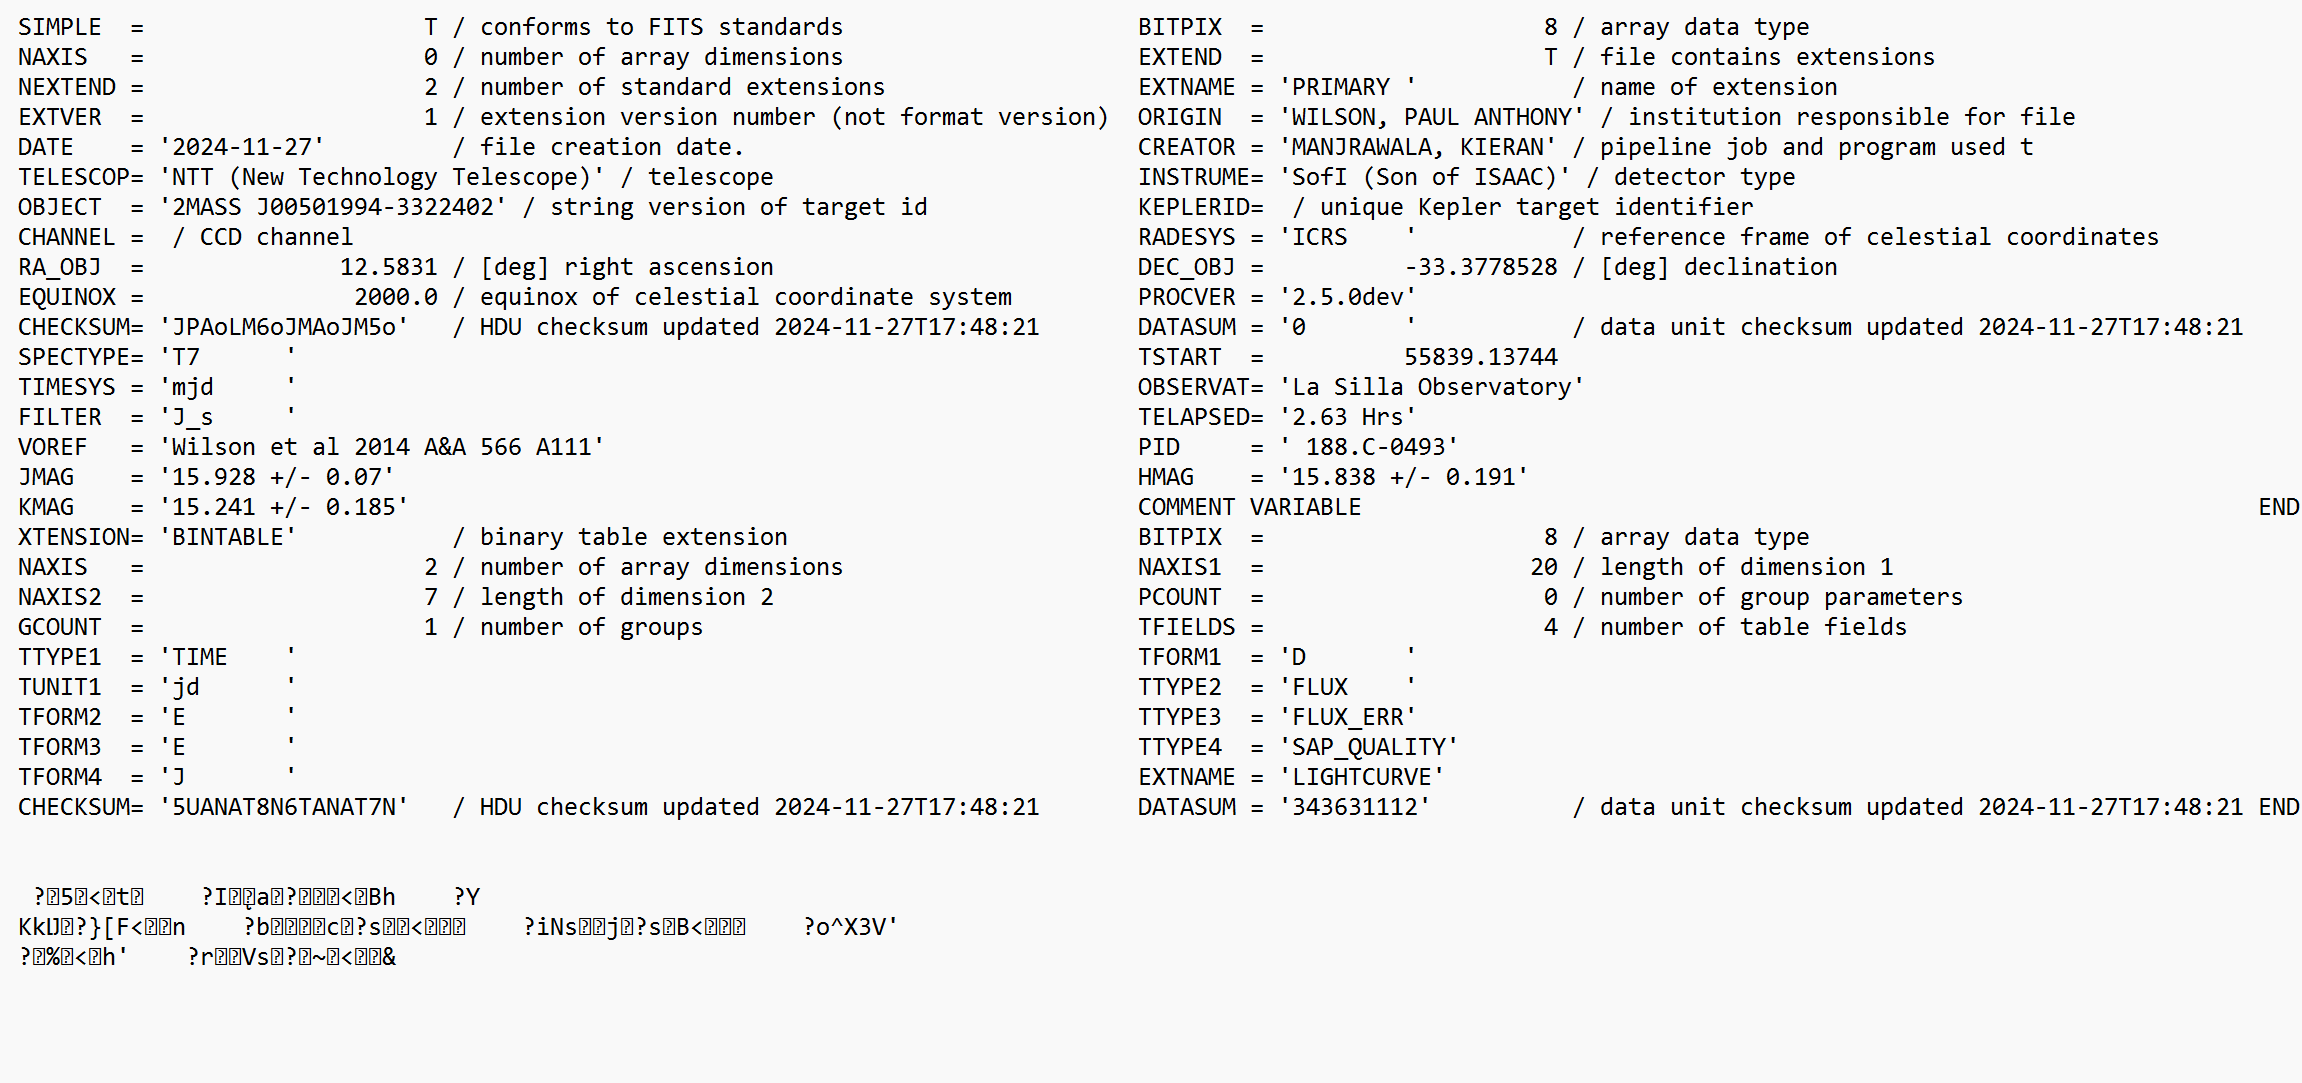

##### Reading the created fits file

In [95]:
# Using the read_generic_lightcurve package, we can read the created fits file directly in as a lightkurve object

lc2 = read_generic_lightcurve("C:/Users/kmanj/Manjavacas Research/Example/File.fits", time_format = 'mjd') # time_format must be specified

In [96]:
lc2

time,flux,flux_err,sap_quality
,,,
Time,float32,float32,int32
0.0,1.025076985359192,0.008999999612569809,0
0.0007637500000000075,1.0596309900283813,0.008988000452518463,0
0.0015283333333333537,0.9896739721298218,0.009019000455737114,0
0.0022783333333333267,0.9521260261535645,0.009003999643027782,0
0.003089166666666643,0.9528390169143677,0.00900499988347292,0
0.0038291666666666613,1.0167820453643799,0.008996999822556973,0
0.00456916666666668,1.003870964050293,0.009033000096678734,0


In [99]:
lc2_header = fits.getheader("C:/Users/kmanj/Manjavacas Research/Example/File.fits")
lc2_header # This is helpful as it makes all header components callable and useable in the script

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
ORIGIN  = 'WILSON, PAUL ANTHONY' / institution responsible for file             
DATE    = '2024-11-27'         / file creation date.                            
CREATOR = 'MANJRAWALA, KIERAN' / pipeline job and program used t                
TELESCOP= 'NTT (New Technology Telescope)' / telescope                          
INSTRUME= 'SofI (Son of ISAAC)' / detector type                                 
OBJECT  = '2MASS J00501994-3

##### Plotting the files using the read_generic_lightcurve package

<Axes: xlabel='Time', ylabel='Flux'>

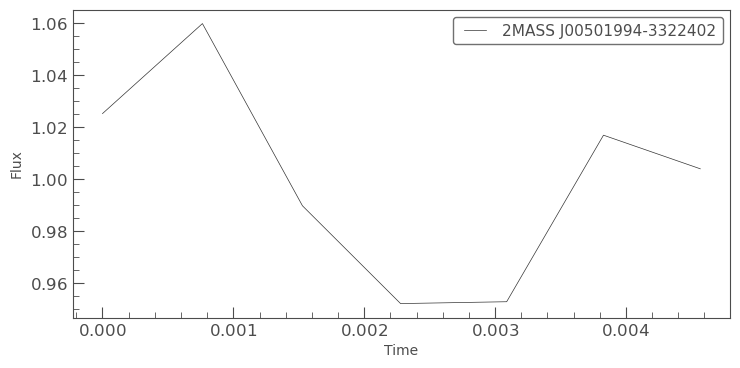

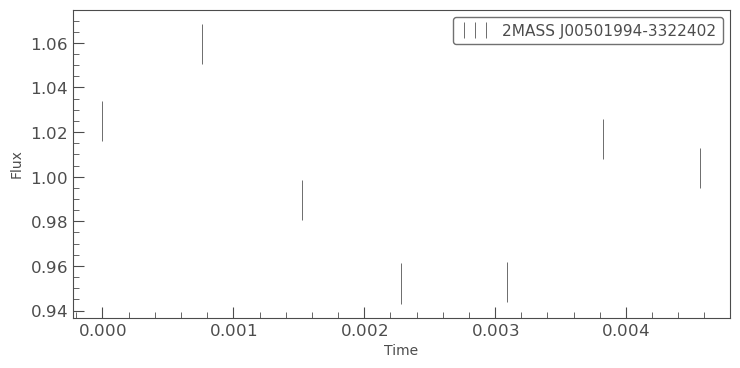

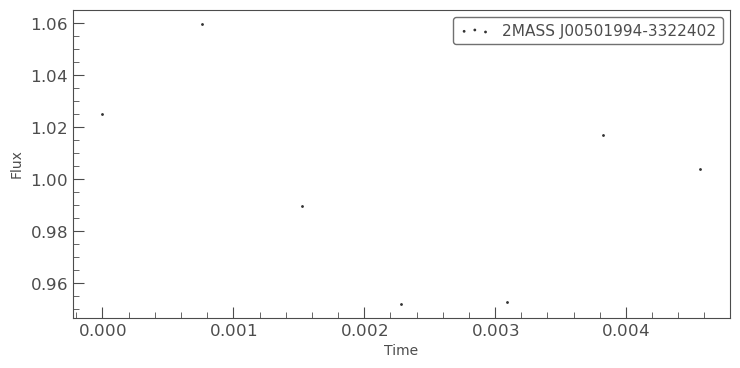

In [100]:
lc2.plot()
lc2.errorbar()
lc2.scatter()

In [101]:
lc2['time']

<Time object: scale='tdb' format='mjd' value=[0.         0.00076375 0.00152833 0.00227833 0.00308917 0.00382917
 0.00456917]>

##### Example of no flux_err input

Column `flux` has no associated errors.


<Axes: xlabel='Time', ylabel='Flux'>

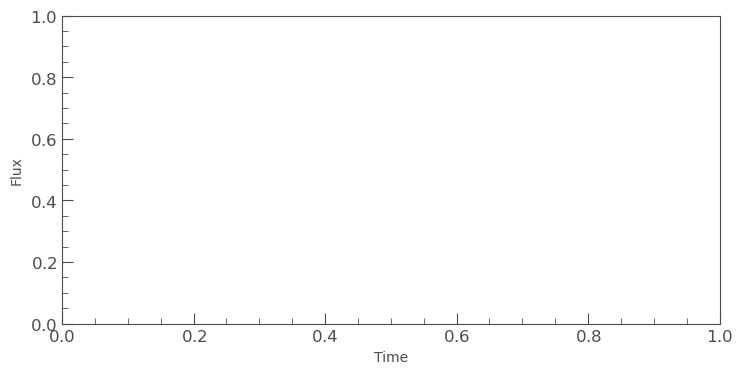

In [42]:
lc = l.LightCurve(time = t, flux = f, flux_err = None, time_format = 'mjd')
lc.errorbar()

Column `flux` has no associated errors.


<Axes: xlabel='Time', ylabel='Flux'>

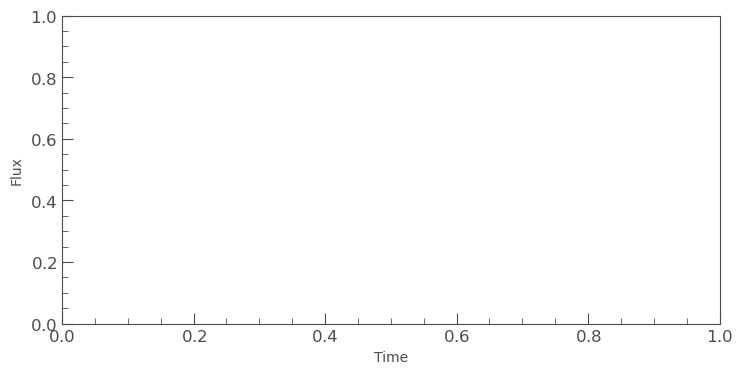

In [43]:
lc = l.LightCurve(time = t, flux = f, time_format = 'mjd')
lc.errorbar()

<Axes: xlabel='Time [JD]', ylabel='Flux'>

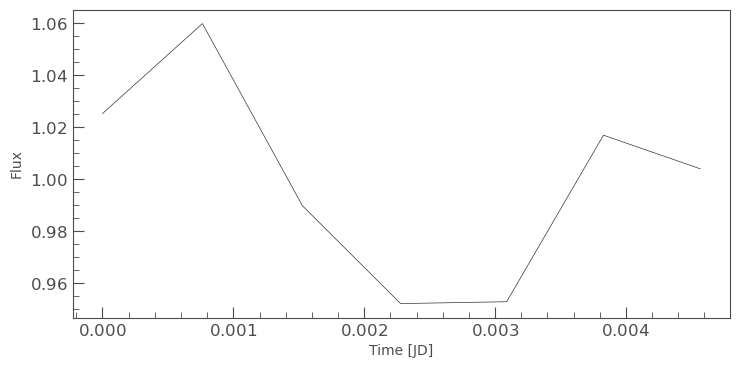

In [78]:
lc.plot()

    Per the latest meeting with the SIMPLE team in the week of 9/9/24, this is the best we have in terms of options for     keyword headers and formatting. There will still be questions as to the keywords and units used on the x and y axis. JD seems to currently be the best option as it results in fractional days which starts at 0, which is true for much data ingested within our archive. 